This notebook contents are:

    (0) load model
    (1) image recognition
    (2) estimating RF(receptive field) by reverse correlation 
    (3) estimating RF by activation maximization
    (4) estimating prefered image by activation maximization (not only for first layer)
    (5) encoding and decoding experiment using Alexnet instead of a real brain
    (6) estimating tuning curve for orientation stimulus
    (7) decoding orientation using estimated tuning curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imresize
from scipy import interpolate
import pickle
import pandas as pd
import time
import os

import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import serializers
from chainer import optimizers





In [3]:
#directory setting
data_dir = 'data'
model_dir = 'model'
fig_dir = 'fig'
temp_dir = 'temp'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [4]:
class Alex(chainer.Chain):
    #structure of Alexnet
    def __init__(self):
        super(Alex, self).__init__(
            conv1=L.Convolution2D(None,  96, 11, stride=4),
            conv2=L.Convolution2D(None, 256,  5, pad=2),
            conv3=L.Convolution2D(None, 384,  3, pad=1),
            conv4=L.Convolution2D(None, 384,  3, pad=1),
            conv5=L.Convolution2D(None, 256,  3, pad=1),
            fc6=L.Linear(None, 4096),
            fc7=L.Linear(None, 4096),
            fc8=L.Linear(None, 1000)
        )
        self.dropout_rate = 0.1
    
        
    def __call__(self, x, layers):
        ret = {}
        en = layers[-1]
        h = self.conv1(x)
        if 'conv1' in layers:
            ret.update({'conv1':h})
            if en == 'conv1':
                return ret
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2) 
        h = self.conv2(h)
        if 'conv2' in layers:
            ret.update({'conv2':h})
            if en == 'conv2':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2)
        h = self.conv3(h)
        if 'conv3' in layers:
            ret.update({'conv3':h})
            if en == 'conv3':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.conv4(h)
        if 'conv4' in layers:
            ret.update({'conv4':h})
            if en == 'conv4':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.conv5(h)
        if 'conv5' in layers:
            ret.update({'conv5':h})
            if en == 'conv5':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.max_pooling_2d(F.relu(h), 3, stride=2)
        h = self.fc6(h)
        if 'fc6' in layers:
            ret.update({'fc6':h})
            if en == 'fc6':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.fc7(h)
        if 'fc7' in layers:
            ret.update({'fc7':h})
            if en == 'fc7':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.fc8(h)
        if 'fc8' in layers:
            ret.update({'fc8':h})
        h = F.softmax(h)
        if 'prob' in layers:
            ret.update({'prob':h})
        return ret
    
    

# (0) load model

In [5]:
model = Alex()
serializers.load_hdf5('{}/Alex.h5'.format(model_dir),model)

# (1) image recognition

In [6]:
def prepare(img):
    #convert PIL Image to numpy array for chainer
    
    #to numpy array
    img = np.asarray(img)
    if not img.shape == (1,3,227,227):
        #resize image to the size used in Alexnet
        img = imresize(img,np.array([227,227]))
        #to BGR, which is used color order in Alexnet
        img = img[:,:,[2,1,0]]
        #reorder img to order used in chainer and convert dtype to np.float32 for chainer
        img = img.transpose(2,0,1).astype(np.float32)
        #add batch dimension for chainer
        img = np.expand_dims(img,axis=0)
    return img

def check_label(prediction):
    #ラベルを読み込む
    categories = np.loadtxt('{}/labels.txt'.format(data_dir), str, delimiter="\n")

    # スコアとラベルを紐づけスコアの高い順にソートする
    result = zip(prediction.data.reshape((prediction.data.size,)), categories)
    result = sorted(result, reverse=True)

    # 上位10個の結果を表示する
    for i, (score, label) in enumerate(result[:10]):
        print '{:>3d} {:>6.2f}% {}'.format(i + 1, score * 100, label)

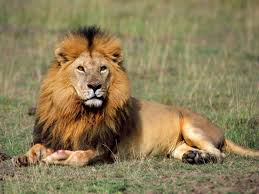

In [7]:
img = Image.open('{}/lion.png'.format(data_dir))
img

In [9]:
img = prepare(img)
prediction = model(img, layers = 'prob')['prob']
check_label(prediction)

  1  46.19% lion, king of beasts, Panthera leo
  2   5.33% chow, chow chow
  3   5.15% dhole, Cuon alpinus
  4   2.30% red fox, Vulpes vulpes
  5   2.00% Pomeranian
  6   1.76% red wolf, maned wolf, Canis rufus, Canis niger
  7   1.75% hyena, hyaena
  8   1.65% collie
  9   1.21% Norwich terrier
 10   1.15% timber wolf, grey wolf, gray wolf, Canis lupus


# (2) estimating RF by reverse correlation 

In [18]:
pos = np.array([14,14]) #where unit
n_sample = 1000

In [19]:
layer_name = 'conv1'

seed = 1
np.random.seed(seed)
img_inps = np.random.rand(n_sample,3,227,227).astype(np.float32) * 255
ua_list = []
#loop for collecting unit activations when random noise images are given
for k in range(n_sample):
    if np.mod(k,100)==0:
        print(k)
    img_inp = img_inps[k:k+1]
    feature = model(img_inp,layers=layer_name)[layer_name]
    unit_activation = feature[0,:,pos[0],pos[1]].data
    ua_list.append(unit_activation)

ua_list = np.array(ua_list)

0
100
200
300
400
500
600
700
800
900


In [59]:
img_inps = np.load('{}/img_random_noise.npy'.format(temp_dir))
ua_list = np.load('{}/unit_act_random_noise.npy'.format(temp_dir))

In [60]:
#estimate RF
#unit activation * input
rf_rc = np.tensordot(img_inps,ua_list,axes = [0,0]).transpose(3,1,2,0)/n_sample

In [13]:
def imshow(img,zoom = False,d=4,pos=pos):
    #show receptive field
    
    #img  : img you want to show
    #zoom : if zoom is True, you zoom and show the image
    #d    : zoom した場合の大きさ。もし0であれば、conv1のRFのサイズになる。
    #pos  : position you want to zoom
    
    if zoom:
        plt.imshow(img[pos[0]*4-d:pos[0]*4 + 11 + d , pos[1]*4 - d : pos[1]*4 + 11 +d])
    else:
        plt.imshow(img)
    plt.axis('off')

def scaling(img):
    #最大値を1、最小値が0になるように線形変換をする。
    temp = img - np.min(img)
    temp = temp/np.max(temp)
    return temp

In [552]:
rf_rc_scaled = np.array([scaling(rf_rc[k]) for k in range(len(rf_rc))])

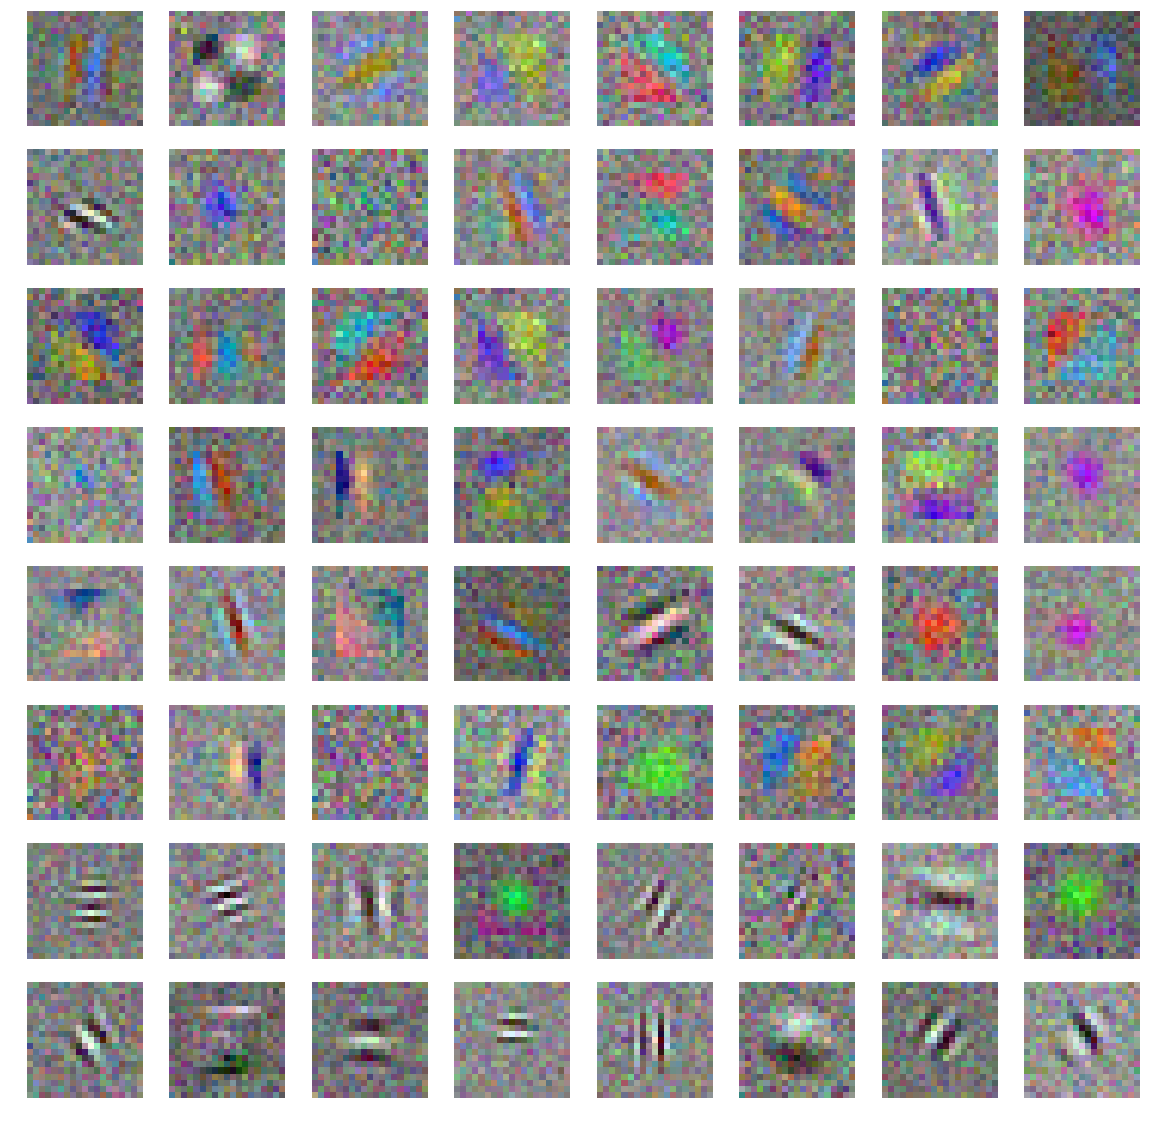

In [553]:
plt.figure(figsize=[20,20])
for ch in range(64):
    plt.subplot(8,8,ch+1)
    imshow(rf_rc_scaled[ch],zoom = True)
plt.savefig('{}/RF_rc'.format(fig_dir))

I compare the true weights and estimated RF in the following chapter 

# (3) estimating RF by activation maximization

In [11]:
class img_model(chainer.Chain):
    #model representing image
    def __init__(self):
        super(img_model,self).__init__(
            img_fc = L.Linear(1,3*227*227)
        )
    def __call__(self):
        return self.img_fc(Variable(np.array(1).reshape(1,1).astype(np.float32))).reshape(1,3,227,227) + 128

In [151]:
def am(layer_name,img_linear,ch=0,pos=np.array([5,5]),lam =0.0001,lr = 1,ite=100,pri = False,show = False):
    #layer_name : layer name
    #ch : channel
    #pos : position of unit (only for conv unit)
    #lam : coefficient of regularization term
    #lr  : initial learning rate
    #ite : iteration of training
    
    opt = optimizers.Adam(alpha = lr)
    opt.setup(img_linear)
    
    img_reg = np.zeros([1,3,227,227]).astype(np.float32) + 128

    
    unit_act = -100
    for _ in range(ite):
#         if np.random.rand()<0.5:
#             img_inp.data = np.roll(img_inp.data,10,axis=2)
#         if np.random.rand()<0.5:
#             img_inp.data = np.roll(img_inp.data,10,axis=3)
        img = img_linear()
        feature = model(img,layers=[layer_name])[layer_name]
#         print(feature.shape)
#         print(fea_target.shape)
        if feature.data.ndim == 2:
            loss = -feature[0,ch] + lam * F.sum((img - img_reg)**2)
        else:
            loss = -feature[0,ch,pos[0],pos[1]] + lam * F.sum((img - img_reg)**2)

        img_linear.cleargrads()
        loss.backward()
        opt.update()
        
        if np.mod(_,10) == 0:
            if pri:
                print('----')
                print('iteration : {}'.format(_))
                print('loss      : {}'.format(loss.data))
            if feature.data.ndim == 2:
                if pri:
                    print('unit act  : {}'.format(feature[0,ch].data))
            else:
                unit_act = feature[0,ch,pos[0],pos[1]].data           
                if pri:
                    print('unit act  : {}'.format(feature[0,ch,pos[0],pos[1]].data))
    
    if show:
        img = img_linear().data[0].transpose(1,2,0)
        img = scaling(img)
        plt.figure(figsize=[10,10])
        plt.imshow(img)
        plt.axis('off')


    
    return img_linear



In [562]:
#AM for RF
out_ch_len = 10
in_ch_len = 1
zure = 0

#estimate RF by AM
rf_am_img = []
for k in range(out_ch_len):
    img_linear = img_model()
    #img_conv1 = am(layer_name = 'conv1',pos = pos, ch = zure + k,ite = 50,lr = 0.1 , lam = 0.0001)
    img_linear = am('conv1',img_linear,pos = pos, ch = zure + k,ite = 50,lr = 0.1 , lam = 0.01,pri = True)
    
    rf_am_img.append(img_linear().data)

rf_am_imgs = np.vstack(rf_am_img)
rf_am_scaled = scaling(rf_am_imgs)
rf_am_scaled = rf_am_scaled.transpose(0,2,3,1)

----
iteration : 0
loss      : 1567.24743652
unit act  : -9.47104263306
----
iteration : 10
loss      : 105.003097534
unit act  : 7.62020921707
----
iteration : 20
loss      : 58.048500061
unit act  : 17.2362518311
----
iteration : 30
loss      : 13.2271461487
unit act  : 21.6673736572
----
iteration : 40
loss      : 0.101324081421
unit act  : 23.4701423645
----
iteration : 0
loss      : 1566.91186523
unit act  : -26.5272026062
----
iteration : 10
loss      : 89.393371582
unit act  : 30.4687843323
----
iteration : 20
loss      : 23.1800689697
unit act  : 77.4809646606
----
iteration : 30
loss      : -29.3739700317
unit act  : 109.466270447
----
iteration : 40
loss      : -45.2039794922
unit act  : 126.89465332
----
iteration : 0
loss      : 1548.75976562
unit act  : -4.76016807556
----
iteration : 10
loss      : 97.2987060547
unit act  : 15.4292392731
----
iteration : 20
loss      : 47.2646064758
unit act  : 29.5430717468
----
iteration : 30
loss      : 1.93452072144
unit act  : 37.623

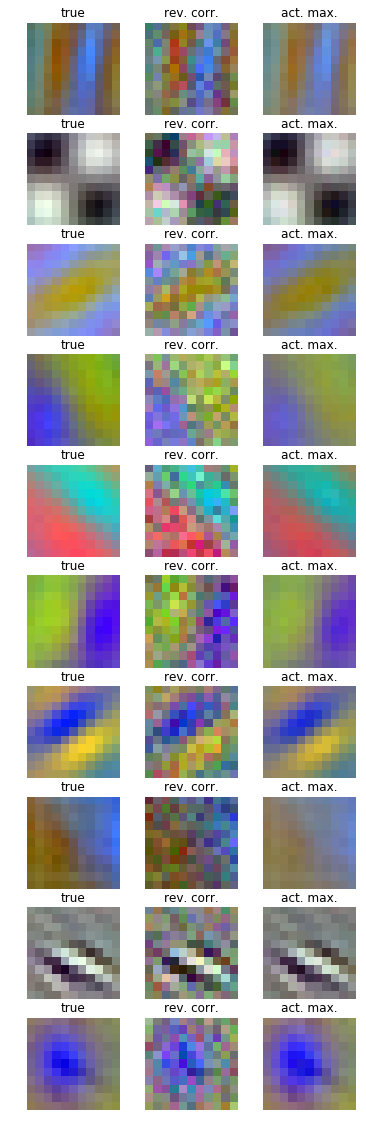

In [563]:
#plot
plt.figure(figsize=[6,2 * out_ch_len])
for out_ch in range(out_ch_len):
    for in_ch in range(in_ch_len):
        
        plt.subplot(out_ch_len,3,1 + 3*out_ch)
        true_weight = model.conv1.W.data[out_ch+zure].transpose(1,2,0)
        true_weight = scaling(true_weight)
        plt.imshow(true_weight)
        plt.axis('off')
        plt.title('true')
        plt.gray()
        
        plt.subplot(out_ch_len,3,2 + 3*out_ch)
        imshow(rf_rc_scaled[out_ch+zure,:,:],zoom=True,d=0)
        plt.title('rev. corr.')
        plt.gray()
        
        plt.subplot(out_ch_len,3,3 + 3*out_ch)
        imshow(rf_am_scaled[out_ch,:,:],zoom=True,d=0)
        plt.title('act. max.')
        plt.gray()
        

plt.savefig('{}/RF_rc_am.png'.format(fig_dir))

# (4) estimating prefered image by activation maximization (not only for first layer)

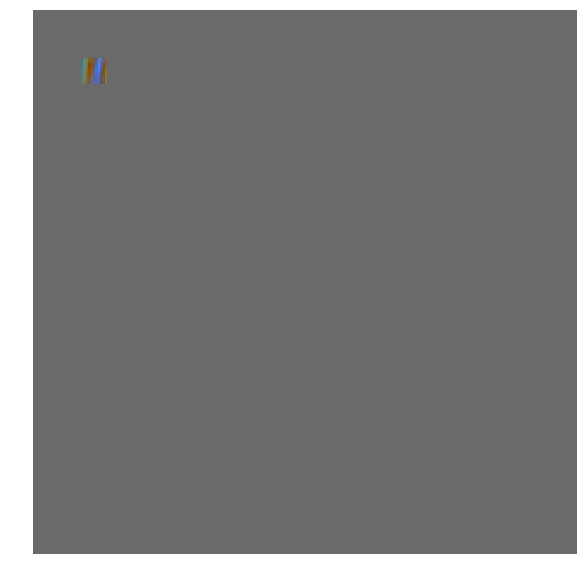

In [14]:
img_linear = img_model()
img_linear = am(layer_name = 'conv1',img_linear=img_linear, show = True,lam = 0.01)
img_conv1 = img_linear()

----
iteration : 0
loss      : 3.17047858238
unit act  : -1.61993706226
----
iteration : 10
loss      : -91.4643783569
unit act  : 105.351234436
----
iteration : 20
loss      : -135.643035889
unit act  : 164.53036499
----
iteration : 30
loss      : -153.754379272
unit act  : 190.341934204
----
iteration : 40
loss      : -166.433837891
unit act  : 203.979125977
----
iteration : 50
loss      : -175.285247803
unit act  : 212.255050659
----
iteration : 60
loss      : -181.293258667
unit act  : 218.334793091
----
iteration : 70
loss      : -185.664077759
unit act  : 223.032058716
----
iteration : 80
loss      : -190.095428467
unit act  : 227.797683716
----
iteration : 90
loss      : -193.309509277
unit act  : 231.93371582


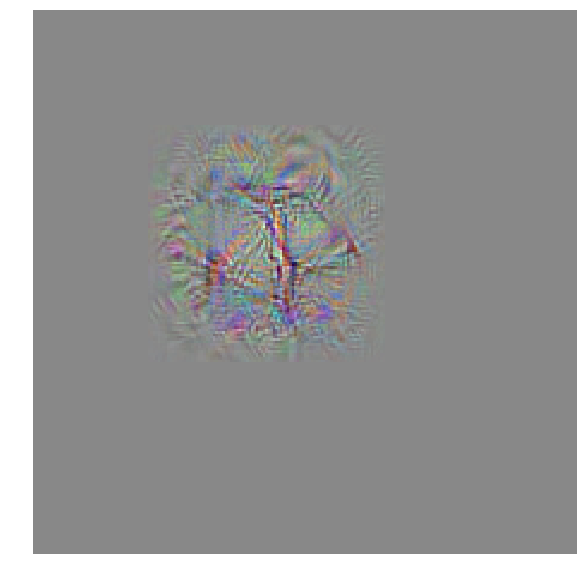

In [588]:
img_linear = img_model()
img_linear = am(layer_name = 'conv3',img_linear=img_linear, ch=0, show = True,lam = 0.00001,pri=True)
img_conv3 = img_linear()

----
iteration : 0
loss      : 1.36050772667
unit act  : 0.181141555309
----
iteration : 10
loss      : -14.4369983673
unit act  : 30.8411808014
----
iteration : 20
loss      : -29.4632110596
unit act  : 52.7650032043
----
iteration : 30
loss      : -39.173324585
unit act  : 65.2913818359
----
iteration : 40
loss      : -44.5365219116
unit act  : 72.0919036865
----
iteration : 50
loss      : -47.8043861389
unit act  : 75.5451202393
----
iteration : 60
loss      : -50.1073989868
unit act  : 78.9938964844
----
iteration : 70
loss      : -51.5443878174
unit act  : 80.2824172974
----
iteration : 80
loss      : -52.319103241
unit act  : 81.2996292114
----
iteration : 90
loss      : -52.7108078003
unit act  : 81.8901748657


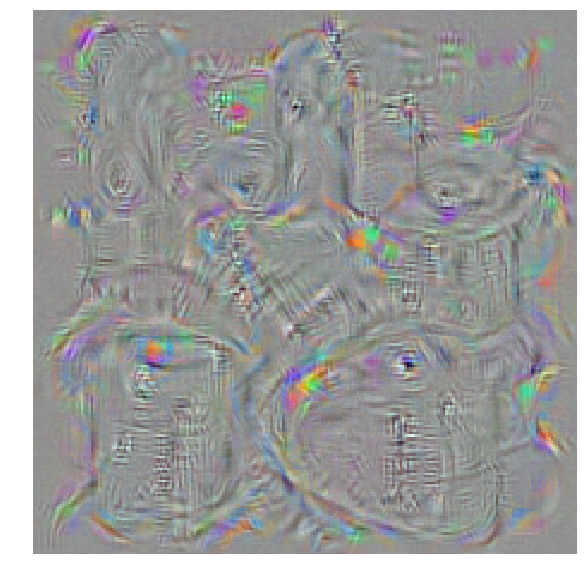

In [589]:
img_linear = img_model()
img_linear = am(layer_name = 'fc6',img_linear=img_linear, ch=0, show = True,lam = 0.00001,pri=True)
img_fc6 = img_linear()

In [585]:
ch = 291
categories = np.loadtxt('{}/labels.txt'.format(data_dir), str, delimiter="\n")
categories[ch]

'lion, king of beasts, Panthera leo'

----
iteration : 0
loss      : 0.115337267518
unit act  : 0.0400567650795
----
iteration : 10
loss      : -7.72213792801
unit act  : 11.4044008255
----
iteration : 20
loss      : -17.7732276917
unit act  : 25.1876487732
----
iteration : 30
loss      : -25.2469558716
unit act  : 35.4215278625
----
iteration : 40
loss      : -30.8367614746
unit act  : 42.3031425476
----
iteration : 50
loss      : -34.9870910645
unit act  : 47.2919845581
----
iteration : 60
loss      : -38.3641967773
unit act  : 51.5010261536
----
iteration : 70
loss      : -40.8520927429
unit act  : 54.7035064697
----
iteration : 80
loss      : -42.7840652466
unit act  : 57.0182571411
----
iteration : 90
loss      : -44.2429924011
unit act  : 58.808429718


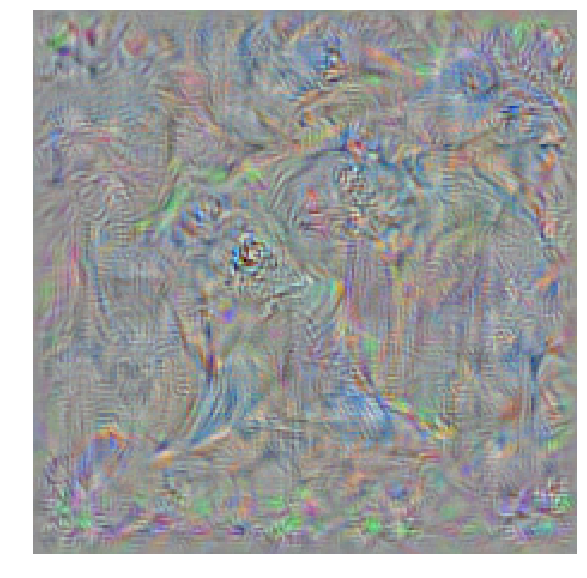

In [582]:
img_linear = img_model()
img_linear = am(layer_name = 'fc8',img_linear=img_linear, ch=291, show = True,lam = 0.000001,pri=True)
img_fc8 = img_linear()

----
iteration : 0
loss      : 1.23718345165
unit act  : -1.08191990852
----
iteration : 10
loss      : -9.4511680603
unit act  : 13.3174676895
----
iteration : 20
loss      : -19.2176780701
unit act  : 27.4438152313
----
iteration : 30
loss      : -27.432352066
unit act  : 38.953792572
----
iteration : 40
loss      : -34.827381134
unit act  : 48.2361602783
----
iteration : 50
loss      : -40.5243110657
unit act  : 55.4816322327
----
iteration : 60
loss      : -38.8399124146
unit act  : 54.2871513367
----
iteration : 70
loss      : -40.7592506409
unit act  : 56.3604164124
----
iteration : 80
loss      : -44.3903083801
unit act  : 60.3768806458
----
iteration : 90
loss      : -44.4983329773
unit act  : 60.6285972595


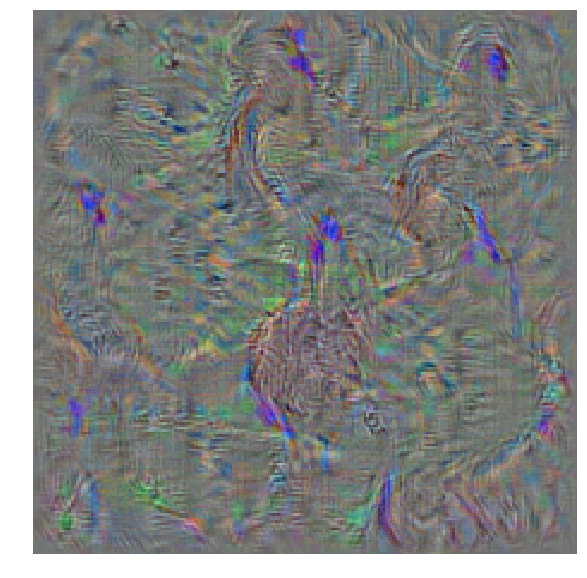

In [152]:
img_linear = img_model()
img_linear = am(layer_name = 'fc8',img_linear=img_linear, ch=100, show = True,lam = 0.000001,pri=True)
img_fc8 = img_linear()

In [584]:
check_label(model(img_fc8,layers='prob')['prob'])

  1 100.00% lion, king of beasts, Panthera leo
  2   0.00% cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
  3   0.00% lynx, catamount
  4   0.00% tiger, Panthera tigris
  5   0.00% dhole, Cuon alpinus
  6   0.00% tiger cat
  7   0.00% cheetah, chetah, Acinonyx jubatus
  8   0.00% coyote, prairie wolf, brush wolf, Canis latrans
  9   0.00% timber wolf, grey wolf, gray wolf, Canis lupus
 10   0.00% warthog


In [591]:
img_list = [img_conv1,img_conv3,img_fc6,img_fc8]
titles = ['conv1','conv3','fc6','fc8']

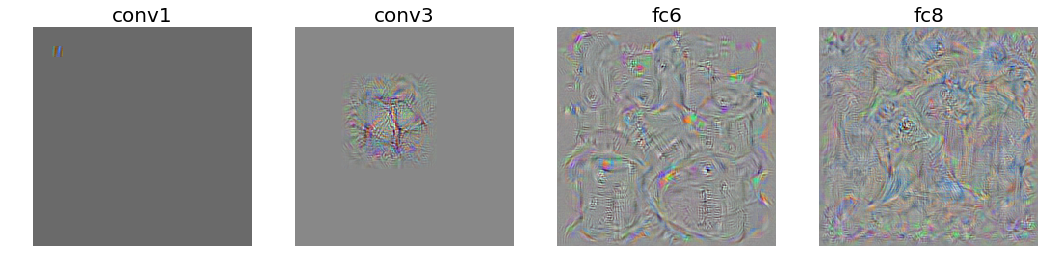

In [592]:
plt.figure(figsize = [18,6])
for k in range(len(img_list)):
    plt.subplot(1,len(img_list),k+1)
    plt.imshow(scaling(img_list[k].data[0].transpose(1,2,0)))
    plt.title(titles[k],fontsize = 20)
    plt.axis('off')

plt.savefig('{}/activation_maximization'.format(fig_dir))

# (5) encoding and decoding experiment using Alexnet instead of a real brain

In [12]:
def collect_unit_act(model,img,label,n_unit,n_class,selected_unit_list):
    #collect unit activity with presenting image to Alexnet
    #model  : model such as Alexnet
    #img    : stimulus images
    #label  : classes of stimulus images
    #n_unit : how many unit
    #n_class: how many class
    #selected_unit_list : which unit you use
    
    #return : dictionary containing unit activities and class information
    d = {}
    for ln in ln_list:
        d[ln] = []
    d['class'] = []

    for cl in range(n_class):
        d['class'].append(cl)
        feature = model(img[label == cl][:n_unit],layers=ln_list)
        for ln,su in zip(ln_list,selected_unit_list):
            temp = feature[ln][:].data
            d[ln].append(temp.reshape(len(temp),temp.size/len(temp))[:,su])
    return d


def log_gauss_p(x,m,sig):
    # return logarithm of gaussian probability 
    sig = sig + 1e-8
    return -0.5 * np.log(2 * np.pi) - np.log(sig) - (x-m)**2/2/sig**2

def inference(x,m_list,s_list,n_class):
    # infer class
    
    # x : unit activity that you want to estimate the class
    # m_list : mean of train unit activities
    # s_list : std  of train unit activities
    # n_class : number of candidate class
    p = []
    for k in range(n_class):
        p.append(np.sum(log_gauss_p(x,m_list[k],s_list[k])))
    return np.argmax(p)




In [13]:
def encode_decode(data,n_unit,n_train,n_test,model):
    #n_class = len(data['Category'])
    n_class = 4
    
    #prepare data
    img_train = np.array(data['ImageTrain']).transpose(0,3,1,2).astype(np.float32)
    img_train = img_train[:,[2,1,0],:,:]
    label_train = np.array(data['LabelTrain'])
    img_test = np.array(data['ImageTest']).transpose(0,3,1,2).astype(np.float32)
    img_test = img_test[:,[2,1,0],:,:]
    label_test = np.array(data['LabelTest'])


    #initialize
    feature = model(img_train[0:1], layers=ln_list)
    n_unit_list = [len(feature[ln].data.flatten()) for ln in ln_list]
    selected_unit_list = [np.random.permutation(n_unit_ori)[:n_unit] for n_unit_ori in n_unit_list]

    # collect unit activity using training data
    print('collecting train data')
    d_train = collect_unit_act(model,img_train,label_train,n_train,n_class,selected_unit_list)

    # collect unit activity using testing data
    print('collecting test data')
    d_test = collect_unit_act(model,img_test,label_test,n_test,n_class,selected_unit_list)

    train = pd.DataFrame(d_train)
    test = pd.DataFrame(d_test)

    #最優推定
    #ユニットの活動はガウシアンであると仮定
    print('estimating')
    acc_list = []
    for ln in ln_list:
        #data preparation
        x_train = np.stack(train[ln].values)
        x_train = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])

        y_train = train['class'].values
        y_train = np.repeat(y_train,n_train)
        x_test = np.stack(test[ln].values)
        x_test = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])
        y_test = test['class'].values
        y_test = np.repeat(y_test,n_test)
        

        #train (estimate mean and std in each class)
        m_list = []
        s_list = []
        for k in range(n_class):
            temp = x_train[y_train == k]
            m = np.mean(temp,axis=0)
            s = np.std (temp,axis=0)
            m_list.append(m)
            s_list.append(s)
        #ML
        pred = []
        for k in range(len(x_test)):
            pred.append(inference(x_test[k,:],m_list,s_list,n_class))

        acc = np.mean(np.array(pred) == y_test)
        acc_list.append(acc)
    

#     plt.figure(figsize=[20,10])
#     plt.plot(acc_list)
#     plt.hlines(1.0/n_class,0,len(acc_list))
#     a = plt.xticks(np.arange(len(acc_list)),ln_list)
#     plt.ylabel('accuracy')
#     plt.xlabel('layer name')
    
    return acc_list

In [14]:
#load image data
with open('./data/Orientation.pickle','rb') as f:
    data_orientation = pickle.load(f)
with open('./data/ImageNet.pickle','rb') as f:
    data_image = pickle.load(f)
with open('./data/FMD.pickle','rb') as f:
    data_fmd = pickle.load(f)
    

In [15]:
#setting
ln_list = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
n_unit=1000 #number of unit used in this analysis ( n <= 1000)
model.dropout_rate = 0.5 
n_train = 40 #training data size (n <= 40)
n_test = 10 #testing data size (n <= 10)


In [ ]:
# perform encoding decoding analysis
print('orientation start')
acc_orientation = encode_decode(data_orientation,n_unit,n_train,n_test,model)
print('imagenet start')
acc_imagenet = encode_decode(data_image,n_unit,n_train,n_test,model)
print('FMD start')
acc_fmd = encode_decode(data_fmd,n_unit,n_train,n_test,model)

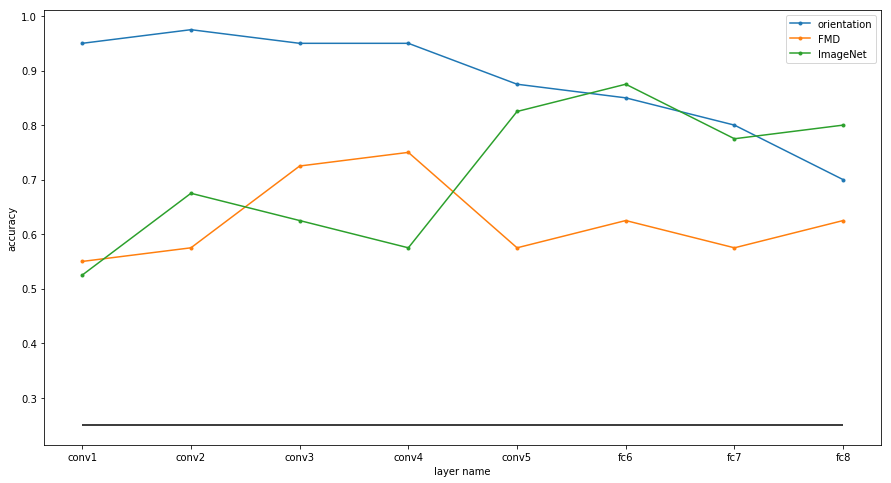

In [75]:
#plot
plt.figure(figsize=[15,8])
plt.plot(acc_orientation,'.-',label = 'orientation')
plt.plot(acc_fmd,'.-',label = 'FMD')
plt.plot(acc_imagenet,'.-',label = 'ImageNet')
plt.hlines(1.0/4,0,len(acc_fmd)-1)
a = plt.xticks(np.arange(len(acc_fmd)),ln_list)
plt.ylabel('accuracy')
plt.xlabel('layer name')
plt.legend()
plt.savefig('{}/enc_dec_acc'.format(fig_dir))

# (6) estimating tuning curve for orientation stimulus

In [140]:
def make_data(theta,omega,k=0,show = False):
    # make orientation image
    img = orientation_image(227, theta=theta,omega = omega,k = k)
    img = imresize(img,np.array([227,227]))
    if show == True:
        plt.imshow(img)
        plt.gray()
        plt.axis('off')
    img = np.repeat(np.expand_dims(img,axis=0),3,axis=0).astype(np.float32)
    return img

def orientation_image(size,theta,omega,k = 0):
    # make orientation image
    x=np.arange(-size/2.0,size/2.0)
    y=np.arange(-size/2.0,size/2.0)

    xx=np.matlib.repmat(x,len(x),1)
    yy=np.matlib.repmat(y,len(y),1).T
    
    xy_rotation=xx*np.cos(theta + np.pi/2)+yy*np.sin(theta - np.pi/2)
    wave=np.cos(xy_rotation*omega+k)

    return(wave)

def pi_to_deg(x):
    return x/np.pi*180
    

In [150]:
#show orientation image to the model
m_list = []
s_list = []

n_ori = 32 # 
omega = 0.01 * 65

for k in range(n_ori + 1):
    img = make_data(np.pi /n_ori * k,omega)
    img = np.expand_dims(img,axis=0)
    fea = F.relu(model(img,layers=['conv1'])['conv1'])[0].data
    m = [np.mean(f) for f in fea]
    s = [np.std(f) for f in fea]
    m_list.append(m)
    s_list.append(s)
    
s_list = np.array(s_list)
m_list = np.array(m_list)

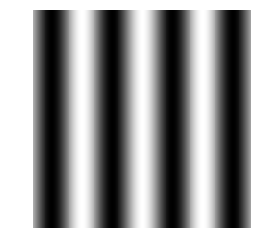

In [148]:
a = make_data(np.pi*0.5,0.1,show=True)

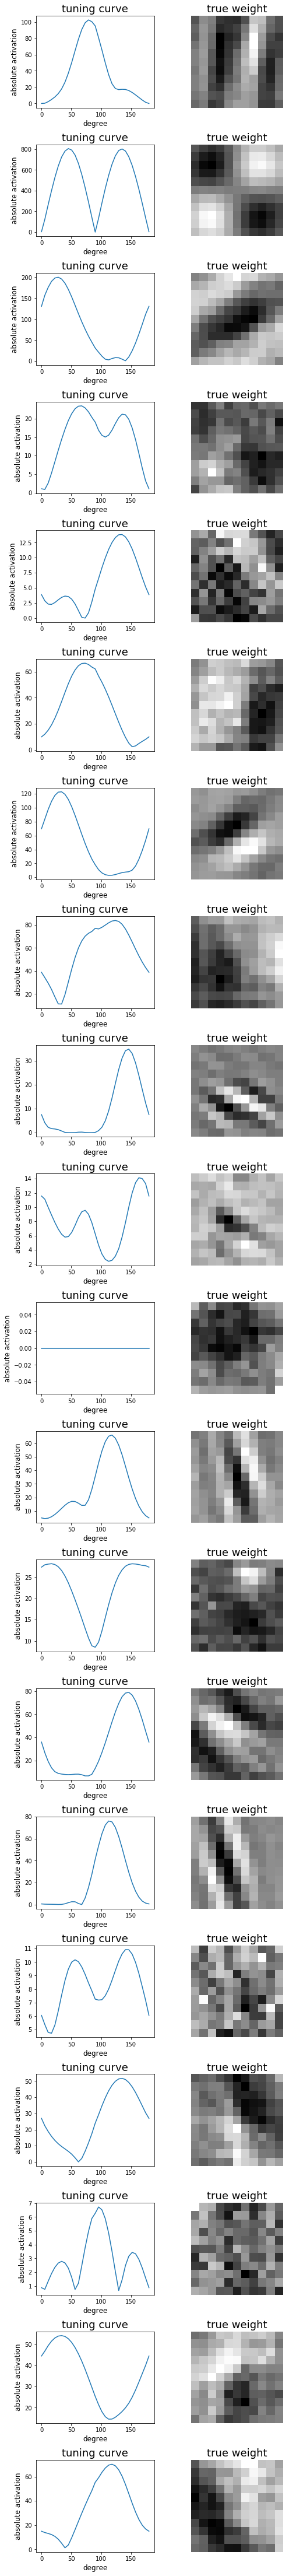

In [151]:
#plot
n_plot = 20
plt.figure(figsize=[4*2,4*n_plot])
for ch in range(n_plot):
    plt.subplot(n_plot,2,2*ch+1)

    temp_tuning = m_list[:,ch]
    temp_x = pi_to_deg(1.0 * np.arange(n_ori+1)/n_ori * np.pi)
    plt.plot(temp_x, temp_tuning)
    plt.ylabel('absolute activation',fontsize=12)
    plt.xlabel('degree',fontsize=12)
    plt.title('tuning curve',fontsize=18)

    plt.subplot(n_plot,2,2*ch+2)
    
    wei = np.mean(model.conv1.W[ch].transpose(1,2,0).data,axis=2)
    plt.imshow(wei)
    plt.axis('off')
    plt.title('true weight',fontsize = 18)
    
plt.subplots_adjust(hspace = 0.4)
plt.savefig('{}/tuning_curve_and_weight'.format(fig_dir))

# (7) decoding orientation using estimated tuning curve

In [105]:
theta_cand = np.linspace(0,np.pi,100)
ans_rec = []
for theta in theta_cand:
    img = make_data(theta,0.01 * 65,show = False)
    img = np.expand_dims(img,axis=0)
    fea = F.relu(model(img,layers=['conv1'])['conv1']).data[0]
    
    #それぞれのchからユニットを一つずつ取ってくる
    b = [np.random.choice(fea[k].flatten()) for k in range(len(fea))]
    b = np.array(b)

    #尤度
    log_p = 0
    for k in range(len(b)):
        if np.random.rand() < 0.5:#約半分のチャネル
            m_interpolated = interpolate.interp1d(np.arange(33) * np.pi / 32.0,m_list[:,k])
            s_interpolated = interpolate.interp1d(np.arange(33) * np.pi / 32.0,s_list[:,k])
            m = m_interpolated(theta_cand)
            s = s_interpolated(theta_cand)
            log_p += log_gauss_p(b[k],m,s)
    ans = theta_cand[np.argmax(log_p)]
    ans_rec.append(ans)

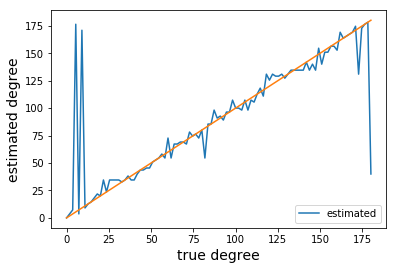

In [106]:
#plot
plt.plot(theta_cand/np.pi*180,np.array(ans_rec)/np.pi*180,label = 'estimated')
plt.plot(theta_cand/np.pi*180,theta_cand/np.pi*180)
plt.xlabel('true degree',fontsize = 14)
plt.ylabel('estimated degree',fontsize = 14)
plt.legend()
plt.savefig('{}/orientation_decoding'.format(fig_dir))

# inverse CNN

In [199]:
def show(x):
    plt.imshow(x[0].transpose(1,2,0)[:,:,[2,1,0]]/255)
    plt.axis('off')

In [200]:
class img_model(chainer.Chain):
    def __init__(self):
        super(img_model,self).__init__(
            img_fc = L.Linear(1,3*227*227)
        )
    def __call__(self):
        return self.img_fc(Variable(np.array(1).reshape(1,1).astype(np.float32))).reshape(1,3,227,227) + 128

In [201]:
def inverse_cnn(layer_name,img_linear,fea_target,ch=0,pos=np.array([5,5]),lam =0.0001,lr = 1,ite=100,pri = False,show = False):
    #layer_name : layer name
    #ch : channel
    #pos : position of unit (only for conv unit)
    #lam : coefficient of regularization term
    #lr  : initial learning rate
    #ite : iteration of training
    opt = optimizers.Adam(alpha = lr)
    opt.setup(img_linear)
    
    img_reg = np.zeros([1,3,227,227]).astype(np.float32) + 128

    
    unit_act = -100
    for _ in range(ite):
#         if np.random.rand()<0.5:
#             img_inp.data = np.roll(img_inp.data,10,axis=2)
#         if np.random.rand()<0.5:
#             img_inp.data = np.roll(img_inp.data,10,axis=3)
        img = img_linear()
        feature = model(img,layers=[layer_name])[layer_name]
        
        loss = F.mean((feature - fea_target)**2)


        img_linear.cleargrads()
        loss.backward()
        opt.update()
        

        if np.mod(_,10) == 0:
            if pri:
                print('----')
                print('iteration : {}'.format(_))
                print('loss      : {}'.format(loss.data))
    
    if show:
        temp = img_inp.data[0].transpose(1,2,0)
        temp = (temp - temp.min())
        temp = temp/np.max(temp)
        plt.figure(figsize=[10,10])
        plt.imshow(temp)
        plt.axis('off')


    
    return img_linear



In [184]:
img_ori = Image.open('{}/geese.png'.format(data_dir))
img_ori = prepare(img_ori)

In [185]:
img = prepare(img)
ln_list = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
#ln_list = ['conv4']
img_result_list = []
fea_size_list = []
for ln in ln_list:
    print(ln)
    fea_target = model(img_ori,layers = ln)[ln]
    fea_size_list.append(fea_target.size)
    img_linear = img_model()
    img_linear = inverse_cnn(ln,img_linear,fea_target,pri = True,ite = 200)
    img = img_linear().data
    img_result_list.append(img)
    
# plt.figure(figsize=[20,20])
# show(img)
# plt.axis('off')

conv1
----
iteration : 0
loss      : 10700.3300781
----
iteration : 10
loss      : 4283.86523438
----
iteration : 20
loss      : 1670.03088379
----
iteration : 30
loss      : 696.322814941
----
iteration : 40
loss      : 331.378967285
----
iteration : 50
loss      : 175.479125977
----
iteration : 60
loss      : 98.6505432129
----
iteration : 70
loss      : 59.3046150208
----
iteration : 80
loss      : 38.4606933594
----
iteration : 90
loss      : 26.6361045837
----
iteration : 100
loss      : 19.4902954102
----
iteration : 110
loss      : 14.8939218521
----
iteration : 120
loss      : 11.7786550522
----
iteration : 130
loss      : 9.57377529144
----
iteration : 140
loss      : 7.95406484604
----
iteration : 150
loss      : 6.72723293304
----
iteration : 160
loss      : 5.77349281311
----
iteration : 170
loss      : 5.01515340805
----
iteration : 180
loss      : 4.40034770966
----
iteration : 190
loss      : 3.89349937439
conv2
----
iteration : 0
loss      : 1946.35241699
----
iteration

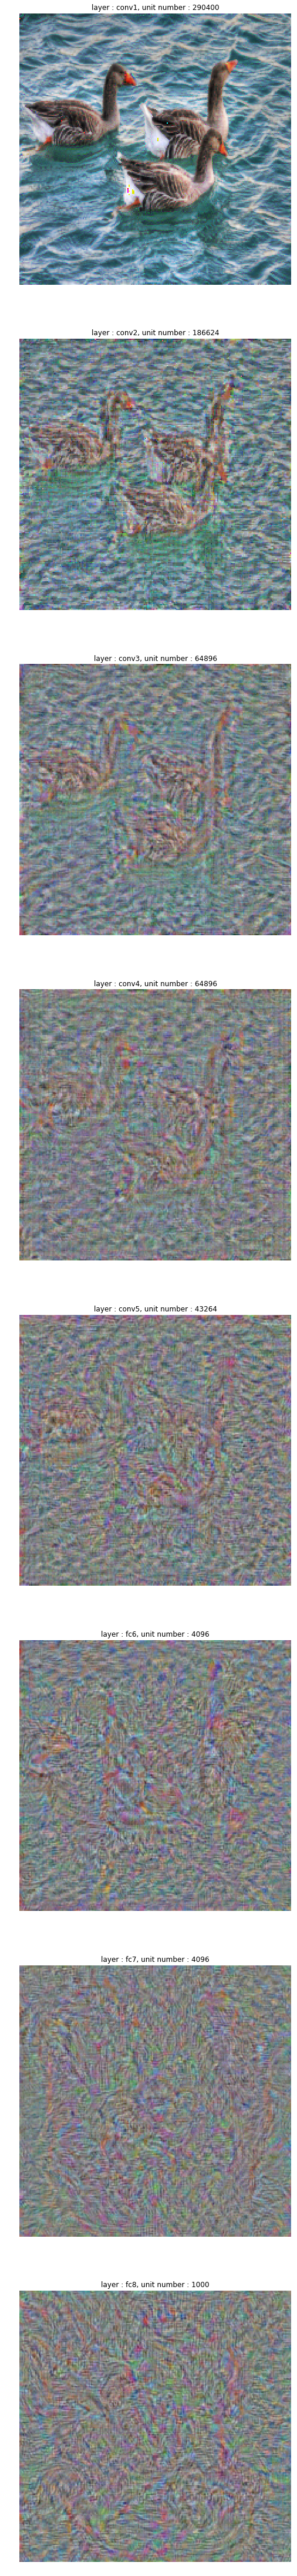

In [198]:
plt.figure(figsize=[10,80])
for k in range(len(img_result_list)):
    plt.subplot(len(img_result_list),1,k+1)
    show(img_result_list[k])
    plt.title('layer : {}, unit number : {}'.format(ln_list[k],fea_size_list[k]))
    plt.axis('off')